![](https://static.tacdn.com/img2/brand_refresh/Tripadvisor_lockup_horizontal_secondary_registered.svg)
# Predict TripAdvisor Rating

* Мельдер Антон
* Группа DSPR-31

## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   

# Table of Contents

1. [IMPORT](#1)
2. [DATA](#2)
3. [CLEANING AND PREPARING DATA](#3)
    * [Обработка NAN ](#3.1)
    * [Обработка признаков](#3.2)
4. [EDA](#4)
    * [Распределение признаков](#4.1)
    * [Распределение целевой переменной Rating](#4.2)
    * [Корреляция признаков](#4.3)
    * [Анализ номинативных переменных](#4.4)

5. [DATA PREPROCESSING](#5)
6. [MODEL](#6)
7. [SUBMISSION](#7)
8. [SUMMARY](#8)

<a id="1"></a>
# 1. IMPORT

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

from itertools import combinations
from scipy.stats import ttest_ind

from sklearn.preprocessing import MultiLabelBinarizer

# для рассчета расстояний между координатами
from math import radians, sin, cos, asin, sqrt

import warnings
warnings.simplefilter('ignore')


sns.set()

%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/cities-data/cities_data.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

<a id="2"></a>
# 2. DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
DATA_DIR2 = '/kaggle/input/cities-data/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
cities_info = pd.read_csv(DATA_DIR2 + 'cities_data.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
cities_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
city                       31 non-null object
country                    31 non-null object
citizens                   31 non-null int64
restaurants_number_TA      31 non-null int64
citizens_per_restaurant    31 non-null int64
tourists_per_year          31 non-null int64
ttl_ppl_per_restaurants    31 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.8+ KB


In [10]:
cities_info.head()

,city,country,citizens,restaurants_number_TA,citizens_per_restaurant,tourists_per_year,ttl_ppl_per_restaurants
0,Amsterdam,Netherlands,872757,3649,239,8354200,2529
1,Athens,Greece,664046,2300,289,5728400,2779
2,Barcelona,Spain,1664182,8622,193,6714500,972
3,Berlin,Germany,3644826,6372,572,5959400,1507
4,Bratislava,Slovakia,437725,1041,420,1400056,1765


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
5360,id_5360,Rome,"['Italian', 'Mediterranean', 'Vegetarian Frien...",359.0,$$ - $$$,705.0,"[[""That's what I was looking for!"", 'Best food...",/Restaurant_Review-g187791-d1788657-Reviews-Ho...,d1788657,0,0.0
25306,id_2164,Barcelona,"['Cafe', 'Mediterranean', 'Healthy', 'Vegetari...",2165.0,$$ - $$$,28.0,"[['Excellent food', 'Gluten and lactose free']...",/Restaurant_Review-g187497-d11906521-Reviews-S...,d11906521,1,4.5
17669,id_3209,Milan,"['American', 'Fast Food', 'Barbecue']",3211.0,$$ - $$$,15.0,"[['Yes.....!'], ['12/10/2017']]",/Restaurant_Review-g187849-d12458867-Reviews-H...,d12458867,1,3.5
18736,id_1507,Athens,"['Sushi', 'Japanese']",1509.0,NaN,14.0,"[[""Good neighbourhood Japanese, but not a 'de....",/Restaurant_Review-g189400-d7134772-Reviews-Su...,d7134772,1,4.0
39124,id_314,Stockholm,NaN,315.0,NaN,38.0,"[['Very surprised', 'Dinner before Ericsson Gl...",/Restaurant_Review-g189852-d8494144-Reviews-Hy...,d8494144,1,4.5


In [16]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

<a id="3"></a>
# 3. CLEANING AND PREPARING DATA

<a id="3.1"></a>
## 3.1. Обработка NAN 

Посмотрим вцелом на наличие пустых значений и определим стратегию работы с ними.

In [17]:
def intitial_eda_checks(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также процент значений NaN
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]

        missing_data = pd.DataFrame(pd.concat(
            [series, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:\n \n')
        display(missing_data)

    else:
        print('NaN значения не найдены.')

In [18]:
# Запускаем функцию вывода всех пустых значений
intitial_eda_checks(data, 0)

Сумма и процент значений NaN:
 



,Количество,%
Price Range,0.34722,34.72
Cuisine Style,0.23180,23.18
Number of Reviews,0.06400,6.40
Reviews,0.00004,0.00


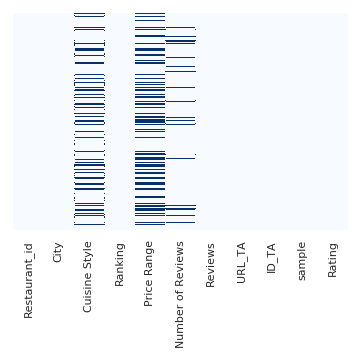

In [19]:
# Посмотрим, как распределены пропуски
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='Blues')



В таблице выведена информация по всем пустым значениям для всех столбцов основного рабочего датасета (data).

    В 4 из 10 столбцов присутствуют пропуски.
    В столбцах Price Range и Cuisine Style очень большое количество пропусков.
    По условию задания строки мы не удаляем, пробуем заменить.

Давайте пройдем по каждому из признаков, где есть пустые значения.


#### Признак Cuisine Style	

Пропущено 23.18% данных. 

Пропуски попробуем заполнить данными с Trip Advisor, но сделаем это позже, в секции формирования новых признаков (см. раздел [3.2 Обработка признаков](#3.2). Пропуски, которые заполнить не удастся реальными данными, заменим на значение 'Unknown'.

#### Признак Price Range

Пропущено 34.72% данных. 

Посмотрим на распределение признака, группировку по городу, рангу, продумаем варианты заполнения.

In [20]:
# Предварительный просмотр данных
data['Price Range'].value_counts(normalize=True)

$$ - $$$    0.705935
$           0.239468
$$$$        0.054597
Name: Price Range, dtype: float64

**Выводы по признаку:** 70% кухонь - средней ценовой категории

**Стратегия заполнения:**
1. Найти данные на внешних ресурсах
2. Значением моды.

In [21]:
data['Price Range'].mode()

0    $$ - $$$
dtype: object

In [22]:
# Заполним пропуски модой
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)

#### Признак Number of Reviews

Пропущено 6.40% данных. 

Посмотрим на распределение признака, группировку по городу, продумаем варианты заполнения.

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

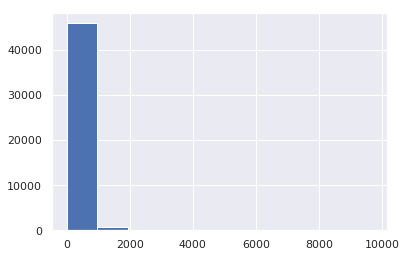

In [23]:
# Предварительный просмотр данных
data['Number of Reviews'].hist()
data['Number of Reviews'].describe()

In [24]:
# Посмотрим на распределение по городам
data.groupby(['City'])[
    'Number of Reviews'].agg(['max', 'min', 'mean', 'median'])

,max,min,mean,median
City,,,,
Amsterdam,6777.0,2.0,148.744436,46.0
Athens,4234.0,2.0,93.987517,22.0
Barcelona,4996.0,2.0,135.683096,35.0
Berlin,2572.0,2.0,63.772188,17.0
Bratislava,2578.0,2.0,51.616099,10.0
Brussels,6437.0,2.0,92.647154,28.0
Budapest,7575.0,2.0,158.680214,24.0
Copenhagen,3426.0,2.0,95.058065,33.0
Dublin,3491.0,2.0,154.276382,44.0


**Выводы по признаку:**
* Есть выбросы => сильное влияние на среднее по всему датасету.
* У 50% данных количество ревью от 9 до 115. Медиана - 33
* Есть зависимость среднего/медианы от города. 

**Стратегия заполнения:**
1. Найти данные на внешних ресурсах
2. Медианным значением в зависимости от города
3. Заполнить нулями

Отсутствие данного значения может быть важной информацией для модели.

Поэтому давайте вынесем все пропуски в отдельный признак (number_of_rev_is_NAN).

In [25]:
# Создаем новый признак
data['number_of_rev_is_NAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')

In [26]:
# Заполняем пропуски медианой по городу
# series с медианами по городам
median_reviews = data.groupby(['City'])['Number of Reviews'].median()
data['Number of Reviews'] = data.apply(lambda x: median_reviews.loc[x['City']] if pd.isna(
    x['Number of Reviews']) else x['Number of Reviews'], axis=1)

#### Признак Reviews

Пропусков очень мало. 

Обработку пустых значений добавила в раздел формирования новых признаков (см. раздел [3.2 Обработка признаков](#3.2)).

Посмотрим еще раз на информацию по пропускам.

In [27]:
# Запускаем функцию вывода всех пустых значений
intitial_eda_checks(data, 0)

Сумма и процент значений NaN:
 



,Количество,%
Cuisine Style,0.23180,23.18
Reviews,0.00004,0.00


<a id="3.2"></a>
## 3.2. Обработка признаков

#### Поиск категориальных признаков для обработки
Для начала посмотрим, какие признаки могут быть категориальными.

In [28]:
data.nunique(dropna=False)

Restaurant_id           13094
City                       31
Cuisine Style           10732
Ranking                 12975
Price Range                 3
Number of Reviews        1576
Reviews                 41858
URL_TA                  49963
ID_TA                   49963
sample                      2
Rating                     10
number_of_rev_is_NAN        2
dtype: int64


Предварительно, категориальными выглядят:
* City
* Price Range
* Cuisine Style.

#### Чистка признака Restaurant_id

Признак Restaurant_id cодержит id_ перед номером, избавимся от префикса.

In [29]:
data.Restaurant_id.sample(1)

44949    id_1017
Name: Restaurant_id, dtype: object

In [30]:
# Почистим формат колонок с ID
data.Restaurant_id = data.Restaurant_id.apply(lambda x: int(x[3:]))
data.ID_TA = data.ID_TA.apply(lambda x: int(x[1:]))
data.Restaurant_id.sample(1)

45814    1697
Name: Restaurant_id, dtype: int64

#### Обработка признака Cousine Style - виды кухни которые предствлены в ресторане

In [31]:
display(data['Cuisine Style'].describe())
display(data['Cuisine Style'].isna().value_counts())

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object

False    38410
True     11590
Name: Cuisine Style, dtype: int64

In [32]:
# применим регулярные выражения для поиска наиболее частого встречающегося варианта
cuisine_style = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'")
cuisine_style.explode().value_counts()

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Polynesian                 2
Salvadoran                 1
Latvian                    1
Burmese                    1
Xinjiang                   1
Name: Cuisine Style, Length: 125, dtype: int64

Присутствуют пропуски, наиболее частое встречающиеся значение ['Italian']. Создадим новый признак на основании этого куда положим все виды кухни списком.

In [33]:
mapping = re.compile(r"'(\b.*?\b)'")
data['cuisine_style'] = data['Cuisine Style'].apply(lambda x: 'Vegetarian Friendly' if pd.isnull(
    x) else mapping.findall(x))  # заполним новый признак списком

In [34]:
data['cuisine_style'].explode().value_counts()

Vegetarian Friendly    25611
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Polynesian                 2
Salvadoran                 1
Latvian                    1
Burmese                    1
Xinjiang                   1
Name: cuisine_style, Length: 125, dtype: int64

In [35]:
data['cuisine_count'] = data['cuisine_style'].apply(lambda x: len(x))

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
Restaurant_id           50000 non-null int64
City                    50000 non-null object
Cuisine Style           38410 non-null object
Ranking                 50000 non-null float64
Price Range             50000 non-null object
Number of Reviews       50000 non-null float64
Reviews                 49998 non-null object
URL_TA                  50000 non-null object
ID_TA                   50000 non-null int64
sample                  50000 non-null int64
Rating                  50000 non-null float64
number_of_rev_is_NAN    50000 non-null uint8
cuisine_style           50000 non-null object
cuisine_count           50000 non-null int64
dtypes: float64(3), int64(4), object(6), uint8(1)
memory usage: 5.0+ MB


рассмотрим уже созданный признак cusin_style и создадим новые признаки этом основании - представим что каждому виду кухни будет соответствовать 1, при отсутствии этого вида кухни 0

In [37]:
cuisine_style = data['cuisine_style']

In [38]:
cuisine_style

0                                               [Bar, Pub]
1        [European, Scandinavian, Gluten Free Options, ...
2                                    [Vegetarian Friendly]
3        [Italian, Mediterranean, European, Vegetarian ...
4        [Italian, Mediterranean, European, Seafood, Ve...
                               ...                        
49995    [Italian, Vegetarian Friendly, Vegan Options, ...
49996    [French, American, Bar, European, Vegetarian F...
49997                                    [Japanese, Sushi]
49998    [Polish, European, Eastern European, Central E...
49999                                            [Spanish]
Name: cuisine_style, Length: 50000, dtype: object

In [39]:
# Поскольку в столбце списки, с начала получаем перечень уникальных значений

cuisines = set()

for row in cuisine_style:
    if type(row) == float:
        continue
    for cuisine in row:
        cuisines.add(cuisine)

# Затем создал столбцы для каждой кухни


def find_item(cell):
    if item in cell:
        return 1
    return 0


for item in cuisines:
    data[item] = data['cuisine_style'].apply(find_item)

In [40]:
# Заполняем значением Unknown
data['Cuisine Style'].fillna("Unknown", inplace=True)

In [41]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Bangladeshi,Norwegian,Salvadoran,Italian,Ukrainian,Belgian,g,American,British,Seafood
15717,559,London,"['Chinese', 'Asian', 'Vegetarian Friendly', 'V...",560.0,$$$$,5216.0,[['You go for the view and are surprised by t....,/Restaurant_Review-g186338-d4346684-Reviews-Hu...,4346684,1,...,0,0,0,0,0,0,0,0,0,0
35237,3022,Paris,"['French', 'European']",3023.0,$$ - $$$,99.0,"[['Delightful', 'Worth a stop....'], ['11/18/2...",/Restaurant_Review-g187147-d718155-Reviews-L_E...,718155,1,...,0,0,0,0,0,0,0,0,0,0
7418,7418,Milan,['Pizza'],5402.0,$$ - $$$,7.0,"[[], []]",/Restaurant_Review-g187849-d5617384-Reviews-Pi...,5617384,0,...,0,0,0,0,0,0,0,0,0,0
34442,10250,London,Unknown,10259.0,$$ - $$$,2.0,"[['Friendly', 'Sweet!'], ['12/26/2017', '11/08...",/Restaurant_Review-g186338-d13112133-Reviews-D...,13112133,1,...,0,0,0,0,0,0,1,0,0,0
32893,2706,Prague,"['International', 'Pub', 'Gastropub', 'Czech',...",2712.0,$,17.0,"[['Unfriendly and unwelcoming', 'Tasty local p...",/Restaurant_Review-g274707-d4769734-Reviews-U_...,4769734,1,...,0,0,0,0,0,0,0,0,0,0


Посмотрим, какие появились столбцы в наборе данных:

In [42]:
for column in data.columns:
    print(column)

Restaurant_id
City
Cuisine Style
Ranking
Price Range
Number of Reviews
Reviews
URL_TA
ID_TA
sample
Rating
number_of_rev_is_NAN
cuisine_style
cuisine_count
Healthy
Bar
Brazilian
Ecuadorean
Hawaiian
Uzbek
n
New Zealand
Persian
Tibetan
a
Austrian
Fujian
Nepali
Hungarian
Yunnan
Kosher
Barbecue
Polish
Czech
Latin
Vietnamese
Egyptian
Japanese
Balti
Moroccan
Mediterranean
Colombian
Cambodian
Mexican
Korean
Delicatessen
F
Thai
Jamaican
Soups
Caucasian
Scottish
Middle Eastern
Mongolian
y
V
Eastern European
Latvian
Sri Lankan
Burmese
r
Irish
Greek
Central American
Azerbaijani
Vegan Options
Fast Food
i
Malaysian
German
Afghani
Filipino
Canadian
 
Pub
Southwestern
South American
Tunisian
Cuban
e
Grill
Danish
Albanian
Indian
Portuguese
Native American
European
Turkish
Cajun & Creole
Swiss
Chinese
Central Asian
Indonesian
t
Gluten Free Options
Argentinean
d
Croatian
Diner
Dutch
Romanian
Swedish
Peruvian
Welsh
Polynesian
Wine Bar
Sushi
Spanish
Contemporary
Israeli
Cafe
Taiwanese
Brew Pub
Pizza
Fusion

Удалим вновь образовавшиеся не значащие столбцы:

In [43]:
data.drop(['t', 'l', 'y', 'r', 'i', 'd', ' ', 'n', 'e',
           'F', 'g', 'V', 'a'], axis=1, inplace=True)

In [44]:
for column in data.columns:
    print(column)

Restaurant_id
City
Cuisine Style
Ranking
Price Range
Number of Reviews
Reviews
URL_TA
ID_TA
sample
Rating
number_of_rev_is_NAN
cuisine_style
cuisine_count
Healthy
Bar
Brazilian
Ecuadorean
Hawaiian
Uzbek
New Zealand
Persian
Tibetan
Austrian
Fujian
Nepali
Hungarian
Yunnan
Kosher
Barbecue
Polish
Czech
Latin
Vietnamese
Egyptian
Japanese
Balti
Moroccan
Mediterranean
Colombian
Cambodian
Mexican
Korean
Delicatessen
Thai
Jamaican
Soups
Caucasian
Scottish
Middle Eastern
Mongolian
Eastern European
Latvian
Sri Lankan
Burmese
Irish
Greek
Central American
Azerbaijani
Vegan Options
Fast Food
Malaysian
German
Afghani
Filipino
Canadian
Pub
Southwestern
South American
Tunisian
Cuban
Grill
Danish
Albanian
Indian
Portuguese
Native American
European
Turkish
Cajun & Creole
Swiss
Chinese
Central Asian
Indonesian
Gluten Free Options
Argentinean
Croatian
Diner
Dutch
Romanian
Swedish
Peruvian
Welsh
Polynesian
Wine Bar
Sushi
Spanish
Contemporary
Israeli
Cafe
Taiwanese
Brew Pub
Pizza
Fusion
Arabic
Chilean
Minori

#### Признак CITY

In [45]:
data.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

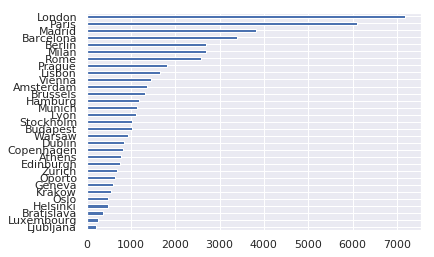

In [46]:
data['City'].value_counts(ascending=True).plot(kind='barh')

Из графика видно, что больше всего ресторанов находится в городе Лондон.

Добавим в нашу выборку новые признаки по городам (данные из интеренета):
* country - страна, в которой находится город
* citizens - население города, чел
* restaurants_number_TA - количество ресторанов, участвующих в рейтинге (TripAdvisor)
* citizens_per_restaurant - количество горожан на один ресторан
* tourists_per_year - количество туристов, посетивших город в течение года, чел
* ttl_ppl_per_restaurants - (количество туристов + население города) / количество ресторанов

In [47]:
# Мержим два датафрейма
cities_info.rename(columns={'city': 'City'}, inplace=True)
data = pd.merge(data, cities_info, on="City", how="left")  # объединяем по City
data.sample(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Belgian,American,British,Seafood,country,citizens,restaurants_number_TA,citizens_per_restaurant,tourists_per_year,ttl_ppl_per_restaurants
6313,6313,Hamburg,Unknown,2398.0,$$ - $$$,6.0,"[[], []]",/Restaurant_Review-g187331-d5826684-Reviews-Fi...,5826684,0,...,0,0,0,0,Germany,1841179,2885,638,1450000,1141


In [48]:
# Посмотрим, сколько уникальных городов
data.City.nunique()

31

В нашей выборке 31 город. Не очень много.
Для данного признака попробуем dymmy-кодирование.

In [49]:
# Создадим признак с копией городов перед кодированием, т.к. изначальная колонка может быть полезной.
data['city_copies'] = data['City']

In [50]:
# Используем One-Hot Encoding в pandas - get_dummies для кодирования городов.
data = pd.get_dummies(data, columns=['City', ], dummy_na=True)

In [51]:
data.sample(2)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
23361,5338,"['Italian', 'Pizza']",5340.0,$$ - $$$,10.0,"[['Very tasty Italian food, very good value f....",/Restaurant_Review-g187323-d2361194-Reviews-Ri...,2361194,1,3.5,...,0,0,0,0,0,0,0,0,0,0
46290,88,"['French', 'Belgian', 'European']",89.0,$$ - $$$,468.0,"[['Yes yes, very special', 'Definitely recomme...",/Restaurant_Review-g188644-d787994-Reviews-Viv...,787994,1,4.0,...,0,0,0,0,0,0,0,0,0,0


#### Признак NUMBER OF REVIEWS

Число отзывов сильно влияет на ранг/рейтинг. При этом во время EDA  было выявлено, что разброс значений очень большой.

Попробуем создать новый признак:
*  reviews_per_ttl_ppl - показывает сколько ревью приходится на суммарное 1000 людей (жители + туристы)

In [52]:
# Создаем новый признак с использованием внешних данных по городам
data['reviews_per_ttl_ppl'] = data.apply(lambda row: (
    row['Number of Reviews']/(row['citizens']+row['tourists_per_year']))*1000, axis=1)

Посмотрим, какое распределение признака получили.

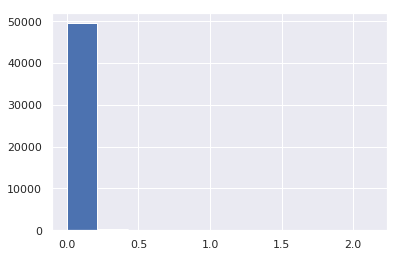

In [53]:
data['reviews_per_ttl_ppl'].hist()

#### Признак PRICE RANGE

Посмотрим, какие значени содержит признак.

In [54]:
data['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$'], dtype=object)

По описанию 'Price Range' это - цены в ресторане. Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами.

Price_range можно разбить на числовой признак от 1 до 3:

    Низкий уровень цен - 1
    Средний ценовой сегмент - 2
    Высокий уровень цен - 3

Код ниже создаёт новый признак price_range_num.

In [55]:
# Создаем словать с кодировкой значений в числовые
pricerange_dict = {"nan": 0, "$": 1, "$$ - $$$": 2, "$$$$": 3}
data['price_range_num'] = data['Price Range']
data['price_range_num'].replace(
    to_replace=pricerange_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [56]:
data.head(2)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,reviews_per_ttl_ppl,price_range_num
0,0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,...,1,0,0,0,0,0,0,0,0.000199,2
1,1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,...,0,0,0,0,0,0,0,0,0.020082,2


#### Признак REVIEWS

Посмотрим на reivews. Видим, что он содержит два ревью с датами ревью.
Мы можем вытащить несколько новых признаков из дат:
* review_date: все даты ревью
* date_rev_1: дата первого ревью
* date_rev_2: дата второго ревью
* date_rev_delta: количество дней между оставленными ревью
* date_rev_from_max: количество дней от последнего отзыва до самого свежего отзыва в датасете.

In [57]:
# Посмотрим, что содержится в столбце с ревью.
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [58]:
# Тип данных - str
type(data.Reviews[1])

str

In [59]:
# В тестовой выборке есть пустые значения, заменим их на строку, которая показывает, что ревью нет.
data['Reviews'].fillna('[[], []]', inplace=True)

In [60]:
# Создадим новый признак review_date на основе патерна поиска дат.
pattern = re.compile('\d+\/\d+\/\d+')
data['review_date'] = data.Reviews.apply(pattern.findall)

data['review_date'].sample(5)

33690    [11/03/2017, 07/11/2017]
13389    [01/25/2017, 12/28/2017]
15226    [05/18/2016, 12/04/2015]
41306    [12/27/2017, 11/16/2017]
11418                          []
Name: review_date, dtype: object

Видим, что review_date может содержать одну дату, две даты, три даты, ни одной даты.

Кодом ниже проверим, есть ли такие ревью, где дата содержалась в самом комментарии и создался список из трёх дат. Да, такие записи есть.
Применим к таким полям функцию, которая первое упоминание из комментариев почистит.

In [61]:
# Напечатать даты, где более двух дат
for i in range(0, len(data)):
    if len(data.review_date[i]) > 2:
        print(i, len(data.review_date[i]))

2221 3
3809 3
19254 3
33348 3


In [62]:
# Чистка данных, где в поле review_date попали даты-упоминания из комментариев отзыва.
data.review_date = data.review_date.apply(
    lambda x: [x[-2], x[-1]] if len(x) > 2 else x)

In [63]:
# Посмотрим, сколько данных, где менее двух отзывов.
count = 0
for i in range(0, len(data)):
    if len(data.review_date[i]) < 2:
        count += 1
count

13794

Создадим признаки:
* date_rev_1: дата первого ревью
* date_rev_2: дата второго ревью
* date_rev_delta: количество дней между оставленными ревью
* date_rev_from_max: количество дней от последнего отзыва до самого свежего отзыва в датасете.
    
>     Информация с TA: Свежие отзывы имеют большую ценность, чем написанные давно. Они дают более точное представление о том, чего в данный момент стоит ожидать от компании. Это значит, что отзывы, которые были написаны давно (независимо от того, положительные они или отрицательные), имеют меньший вес при расчете рейтинга компании, чем отзыв, написанный недавно. Несмотря на то, что устаревшие отзывы не имеют такого же веса в рейтинге, они по-прежнему отображаются в разделе "Обзор" на странице каждого объекта в каталоге и в истории отзывов о компании.

In [64]:
# Создаем новые признаки, сразу переводим в формат datetime64
data['date_rev_1'] = pd.to_datetime(
    data.review_date.apply(lambda x: x[0] if len(x) >= 1 else None))
data['date_rev_2'] = pd.to_datetime(
    data.review_date.apply(lambda x: x[1] if len(x) >= 2 else None))
data['date_rev_delta'] = (
    abs(data.date_rev_2-data.date_rev_1)) / np.timedelta64(1, "D")

In [65]:
# Максимальная дата отзывы в датасете
date_max = data[['date_rev_1', 'date_rev_2']].max(axis=1).max()
date_max

Timestamp('2018-02-26 00:00:00')

In [66]:
# Создаем новый признак про актуальность отзывов
data['date_rev_from_max'] = data.apply(lambda row: None if len(row.review_date) == 0  # если пустые значения, то Nan
                                       # если одна дата, то смотрим разницу с первым отзывом
                                       else (date_max-row.date_rev_1) if len(row.review_date) == 1
                                       else ((date_max-row.date_rev_2)), axis=1) / np.timedelta64(1, "D")  # если два отзыва, то берем второй отзыв

In [67]:
data.sample(3)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Warsaw,City_Zurich,City_nan,reviews_per_ttl_ppl,price_range_num,review_date,date_rev_1,date_rev_2,date_rev_delta,date_rev_from_max
44344,13346,['Italian'],13348.0,$$ - $$$,11.0,"[['Great pizzas', 'racial profiling and terrib...",/Restaurant_Review-g187147-d5014187-Reviews-Re...,5014187,1,3.0,...,0,0,0,0.000547,2,"[10/18/2015, 10/04/2015]",2015-10-18,2015-10-04,14.0,876.0
30712,1335,Unknown,1337.0,$$ - $$$,9.0,"[['Love this place!', '""laptop café""'], ['05/2...",/Restaurant_Review-g189541-d7389368-Reviews-Ka...,7389368,1,4.0,...,0,0,0,0.002442,2,"[05/27/2016, 02/02/2016]",2016-05-27,2016-02-02,115.0,755.0
47506,950,['Polish'],951.0,$$ - $$$,3.0,"[['lovely, quiet, tasty, economical neighborh....",/Restaurant_Review-g274772-d8570940-Reviews-Qu...,8570940,1,4.5,...,0,0,0,0.000854,2,[08/27/2015],2015-08-27,NaT,NaN,914.0


#### Признак Restaurant_ID

Посмотрим на количество уникальный ID из 50 000 записей.

In [68]:
# Количество уникальных ID
data.Restaurant_id.nunique()

13094

Из 50000 записей только 13094 уникальных ID:
* 3807 - рестораны, представленные одним заведением
* Остальные 46193 - сетевые рестораны.

Создадим новый признак "in chain", который будет 
* 0 - если ресторан несетевой, 
* 1 - ресторан сетевой.

In [69]:
# Найдем ID ресторанов, у которых в value_counts более одного ресторана, сохраним список
in_chain_index = data['Restaurant_id'].value_counts(
).loc[lambda x: x > 1].index

In [70]:
# запишем ID ресторанов, у кого value_counts > 1
data['in_chain'] = data['Restaurant_id'].apply(
    lambda x: 1 if x in in_chain_index else 0)

In [71]:
# Посмотрим на получившиеся значения
data['in_chain'].value_counts()

1    46193
0     3807
Name: in_chain, dtype: int64

<a id="4"></a>
# 4. EDA 

<a id="4.1"></a>

### 4.1 Распределение признаков

In [72]:
def get_boxplot_2(column):
    """
    Функция для отрисовки коробочной диаграммы для нечисловых величин.
    На вход получаем список колонок для отрисовки. 
    Отрисовываем относительно целевой переменной Rating.
    """
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Rating',
                data=data[data['sample'] == 1],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для ' + column)
    plt.show()

#### "Служебные признаки"

Признаки, которые не анализируем и которые удалим перед отправкой данных на обучение модели:
* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

#### Признак Restaurant_id -> In_Chain

Мы сгенерировали признак "in chain", посмотрим на него.


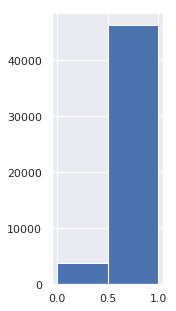

In [73]:
# Посмотрим на распределение признака
plt.rcParams['figure.figsize'] = (2, 5)
data['in_chain'].hist(bins=2)

Посмотрим на распределение других признаков от того, является ли ресторан сетевым.

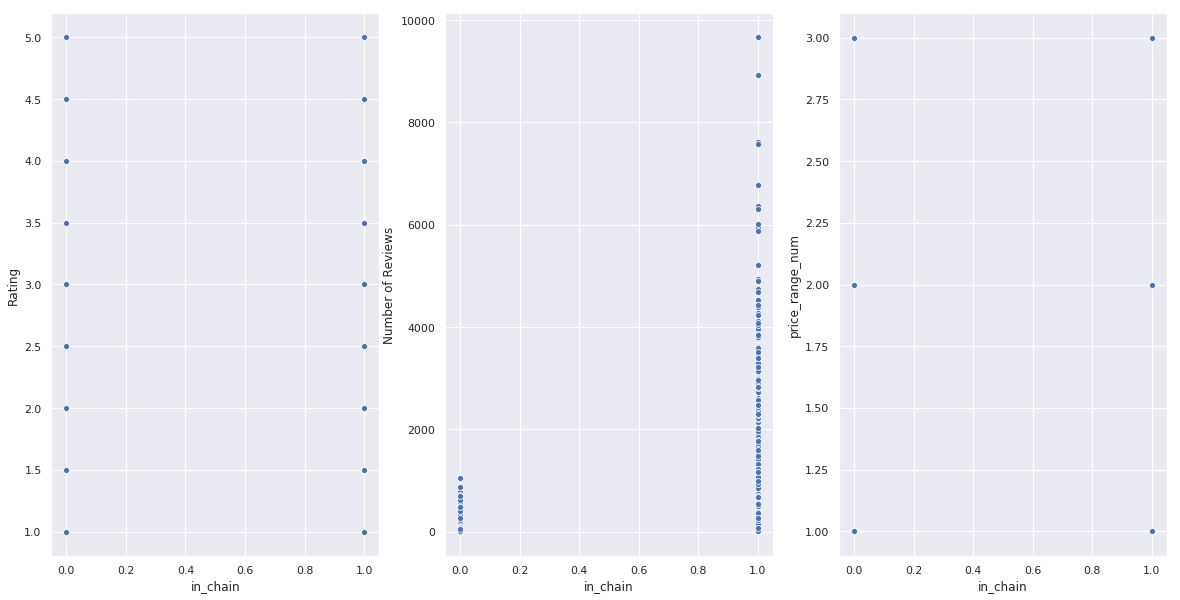

In [74]:
# Посмотрим на распределение других признаков от того, является ли ресторан сетевым
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.scatterplot(data=data[data['sample'] == 1],
                x="in_chain", y="Rating", ax=ax[0])
sns.scatterplot(data=data[data['sample'] == 1],
                x="in_chain", y="Number of Reviews", ax=ax[1])
sns.scatterplot(data=data[data['sample'] == 1],
                x="in_chain", y="price_range_num", ax=ax[2])

Большинство ресторанов - сетевые. Наблюдается зависимость количества отзывов от того, сетевой ли ресторан. У сетевых ресторанов отзывов больше.

#### Признак Ranking

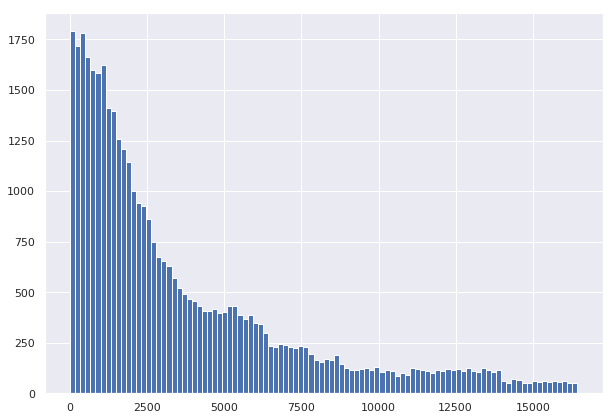

In [75]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

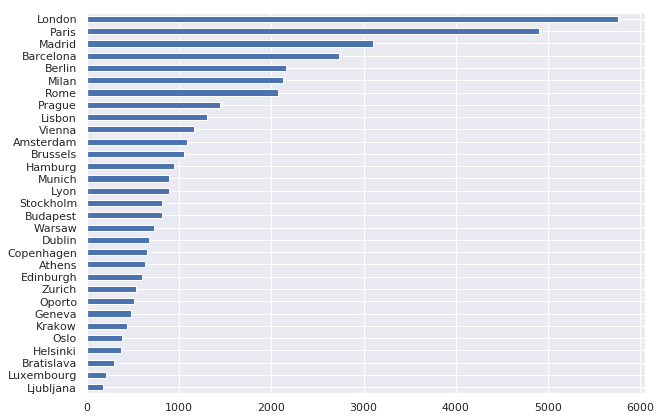

In [76]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе:

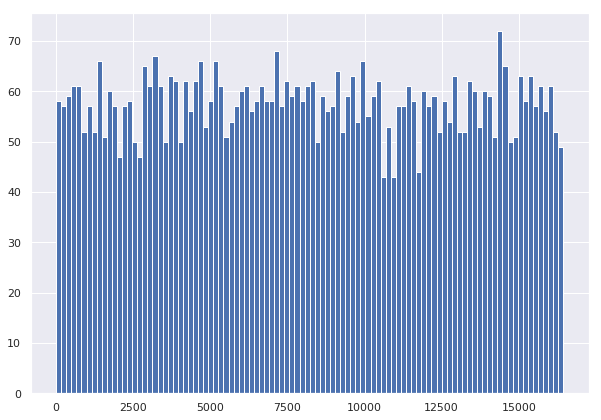

In [77]:
df_train[df_train['City'] == 'London']['Ranking'].hist(bins=100)

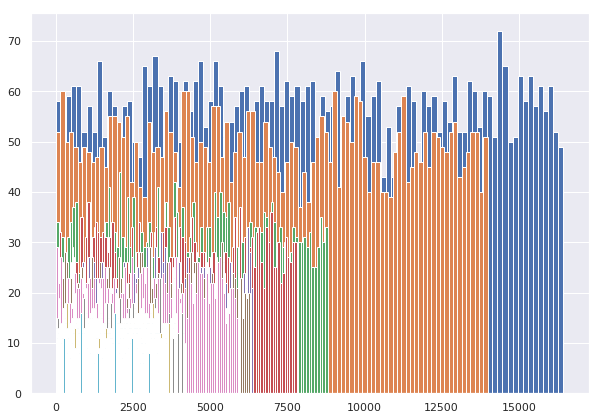

In [78]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого мы имеем смещение.

Чтобы скорректировать признак и сделать его более информативным создадим новый признак: 
* rank_per_ttl - показывает относительную позицию ранга ресторана к общему количеству рангов по городу. Предположила, что количетсво рангов по городу будет близко к общему количеству ресторанов по версии TA.
    Чем больше ранг - тем лучше. Чем меньше rank_per_ttl - тем лучше с позиции рейтинга.

In [79]:
# Создаем признак rank_per_ttl
data['rank_per_ttl'] = data.apply(
    lambda x: x['Ranking']/x['restaurants_number_TA'], axis=1)
data.sample(1)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_nan,reviews_per_ttl_ppl,price_range_num,review_date,date_rev_1,date_rev_2,date_rev_delta,date_rev_from_max,in_chain,rank_per_ttl
41704,2210,"['Japanese', 'Peruvian', 'South American']",2211.0,$$ - $$$,38.0,"[[], []]",/Restaurant_Review-g187147-d11741806-Reviews-L...,11741806,1,4.5,...,0,0.001888,2,[],NaT,NaT,NaN,NaN,1,0.128719


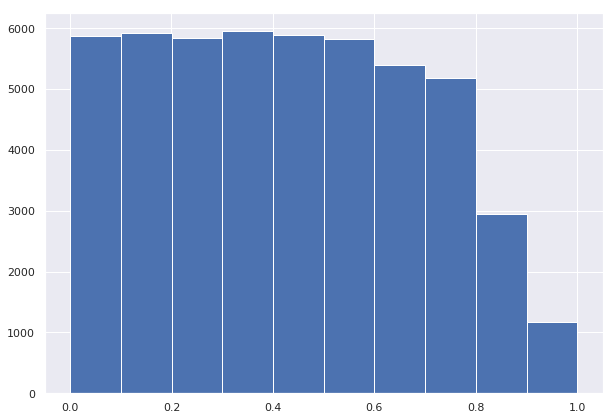

In [80]:
# Смотрим распределение
data['rank_per_ttl'].hist()

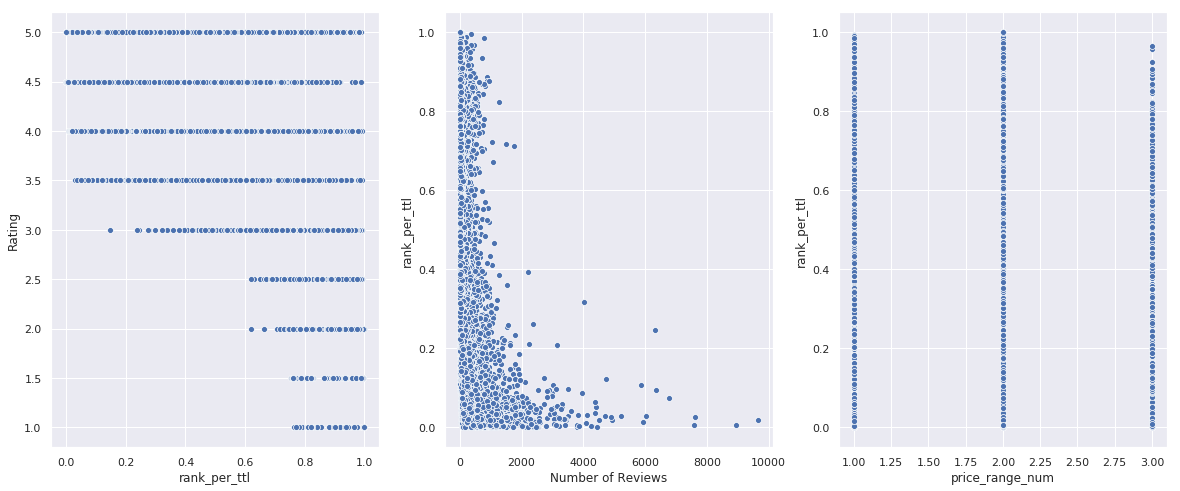

In [81]:
# Посмотрим на распределение других признаков относительно нового признака
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.scatterplot(data=data[data['sample'] == 1],
                x="rank_per_ttl", y="Rating", ax=ax[0])
sns.scatterplot(data=data[data['sample'] == 1],
                x="Number of Reviews", y="rank_per_ttl", ax=ax[1])
sns.scatterplot(data=data[data['sample'] == 1],
                x="price_range_num", y="rank_per_ttl", ax=ax[2])

Для сравнения посмотрим на паспределение изначального Ranking к целевой переменной Rating и другими признаками.

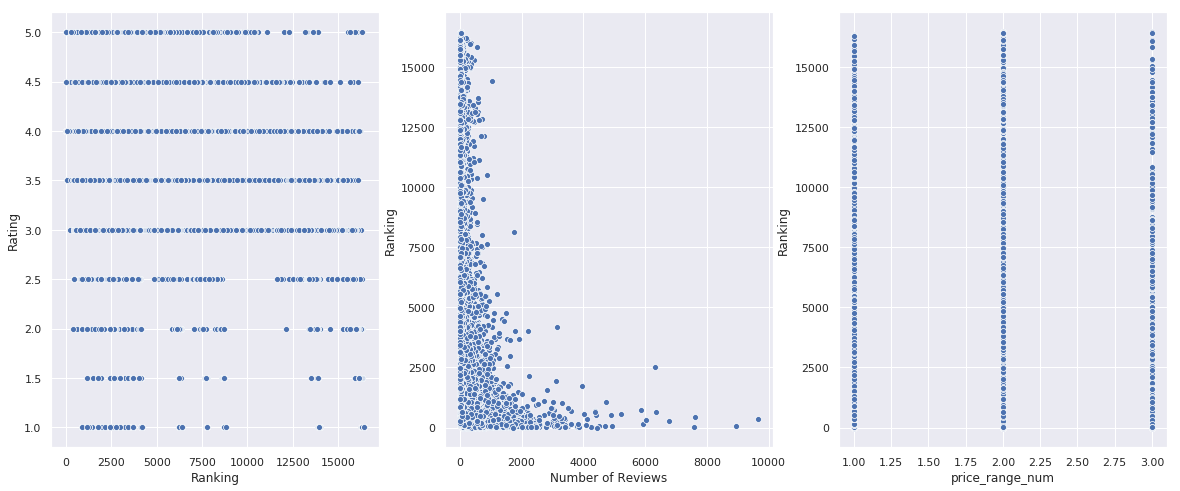

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.scatterplot(data=data[data['sample'] == 1],
                x="Ranking", y="Rating", ax=ax[0])
sns.scatterplot(data=data[data['sample'] == 1],
                x="Number of Reviews", y="Ranking", ax=ax[1])
sns.scatterplot(data=data[data['sample'] == 1],
                x="price_range_num", y="Ranking", ax=ax[2])

Видно, что новый признак имеет более выраженную зависимость с целевой переменной Rating.

**Графики:**
1. чем меньше ранг ресторана, тем чаще встречается более высокий рейтинг. Наличие корреляции с целевым признаком - хорошо для обучения модели.
2. чем меньше ранг ресторана, тем большее количество отзывов

Добавим признаки перемножением двух скоррелированных признаков с Ranking.

In [83]:
# Добавление признаков
data["ranking_num_reviews"] = data["Ranking"] * data["Number of Reviews"]

#### Признак Price Range

Будем использовать для анализа новый признак price_range_num, т.к. он полностью дублирует изначальный признак. Пропуски уже заполнены модой.

count    50000.000000
mean         1.879320
std          0.421189
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: price_range_num, dtype: float64

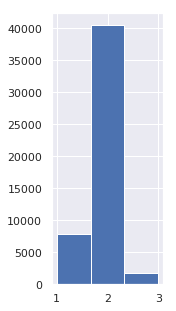

In [84]:
plt.rcParams['figure.figsize'] = (2, 5)
data['price_range_num'].hist(bins=3)
data['price_range_num'].describe()

**Вывод**: большая часть ресторанов средней ценовой категории. Самая немногочисленная часть - дорогие рестораны.

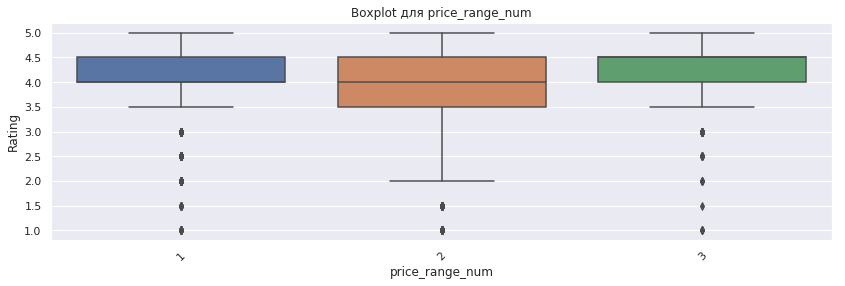

In [85]:
# Посмотрим на распределение рейтингов по ценовым категориям.
get_boxplot_2('price_range_num')

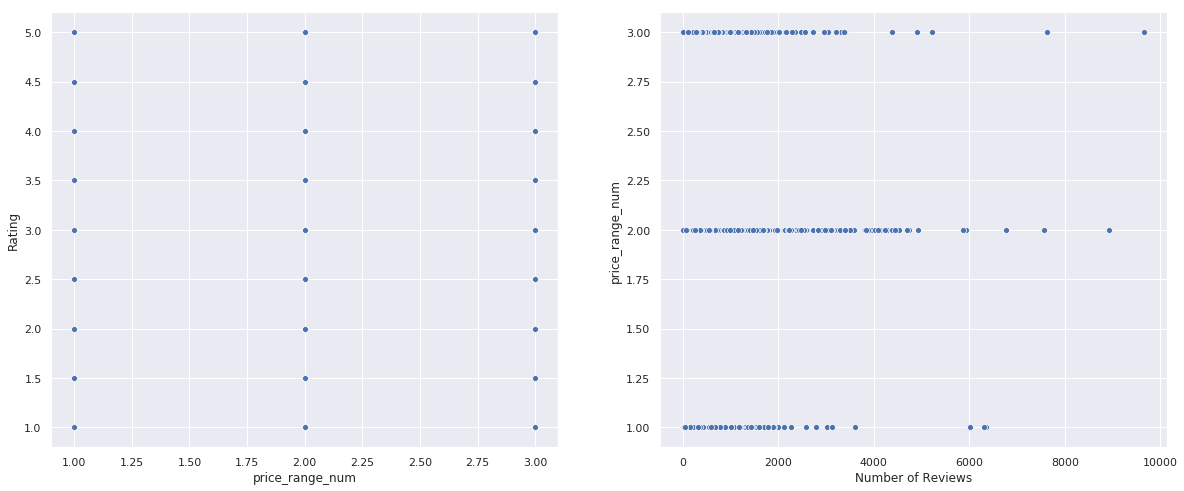

In [86]:
# Поссмотрим зависимость целевой переменной и ценовой категории на тестовой части выборки
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.scatterplot(data=data[data['sample'] == 1],
                x="price_range_num", y="Rating", ax=ax[0])
sns.scatterplot(data=data[data['sample'] == 1],
                x="Number of Reviews", y="price_range_num", ax=ax[1])

**Зависимость целевой переменной и ценовой категории**:
1. Как низкие, так и высокие рейтинги представлены во всех ценовых категориях
2. Наиболее разнообразное распределение рейтингов представлено во 2-ой ценовой категории. По 1-ой и 2-ой значения очень похожи.

Максимальная корреляция ценовой категории с количеством отзывов. Чем категория выше, тем больше отзывов.

#### Признак Number of Reviews

Посмотрим на распределение признака, на зависимость признака от целевой переменной и других переменных.

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

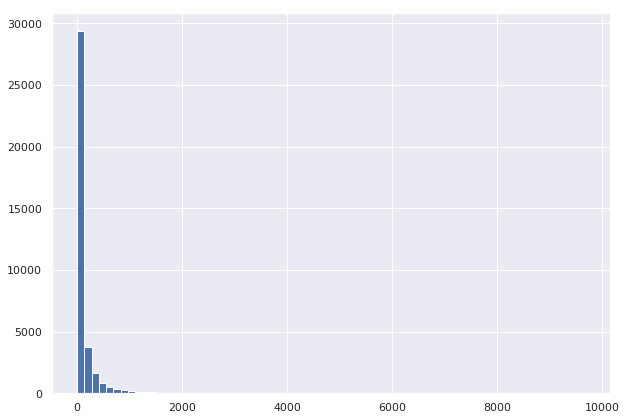

In [87]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Number of Reviews'].hist(bins=70)
df_train['Number of Reviews'].describe()

**Зависимость целевой переменной и ценовой категории**:
1. Как низкие, так и высокие рейтинги представлены во всех ценовых категориях
2. Наиболее разнообразное распределение рейтингов представлено во 2-ой ценовой категории. По 1-ой и 2-ой значения очень похожи.

Максимальная корреляция ценовой категории с количеством отзывов. Чем категория выше, тем больше отзывов.

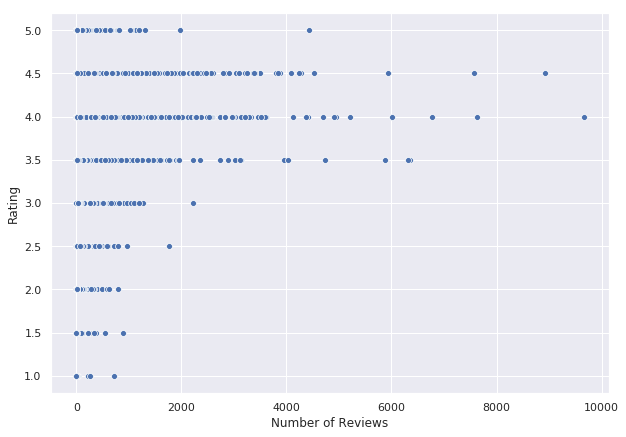

In [88]:
sns.scatterplot(data=df_train, x="Number of Reviews", y="Rating")

Как и в случае с Ranking, количество отзывов очень отличается от ресторана/города (население, поток туристов).

Чтобы получить более информативную картину об отзывах ресторана, создадим новый признак:
* ttl_reviews_per_city - суммарное количество  ревью по городу из выборки
* reviews_perc_in_city_ttl - отношения количества ревью ресторана к суммарному количеству ревью по городу из выборки.

In [89]:
# Создадим датафрейм, в который запишем суммы количества ревью по городам
reviews_sum = pd.DataFrame(data.groupby(['city_copies'])[
    'Number of Reviews'].sum().sort_values(ascending=False))
reviews_sum.rename(
    columns={"Number of Reviews": "ttl_reviews_per_city"}, inplace=True)
reviews_sum

,ttl_reviews_per_city
city_copies,
London,949920.0
Rome,737279.0
Paris,693631.0
Milan,437507.0
Barcelona,437487.0
Madrid,363611.0
Prague,203846.0
Lisbon,199788.0
Amsterdam,196988.0


In [90]:
# Смержим созданный датафрейм с исходным датафреймам по городу
data = pd.merge(data, reviews_sum, on="city_copies", how="left")
data.sample(1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 188 entries, Restaurant_id to ttl_reviews_per_city
dtypes: datetime64[ns](2), float64(9), int64(136), object(8), uint8(33)
memory usage: 61.1+ MB


In [91]:
# Создаем новый признак reviews_perc_in_city_ttl
data['reviews_perc_in_city_ttl'] = data.apply(
    lambda x: x['Number of Reviews']/x['ttl_reviews_per_city'], axis=1)
data.sample(1)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,review_date,date_rev_1,date_rev_2,date_rev_delta,date_rev_from_max,in_chain,rank_per_ttl,ranking_num_reviews,ttl_reviews_per_city,reviews_perc_in_city_ttl
11225,4050,"['French', 'European', 'Vegetarian Friendly', ...",4057.0,$$ - $$$,147.0,"[['Great wine, good food', 'Lovely evening wit...",/Restaurant_Review-g186338-d2417233-Reviews-So...,2417233,1,4.0,...,"[12/28/2017, 12/09/2017]",2017-12-28,2017-12-09,19.0,79.0,1,0.203134,596379.0,949920.0,0.000155


По распределению изначальных данных количества ревью видим, что есть выбросы, устраним их.

In [92]:
def iqr_analysis(series, mode=False):
    """
    Функция выводит инфорамцию о границах выборосов для признака.
    Если mode = True, возвращается верхняя и нижняя границы выбросов.
    """
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if mode:
        return f, l

    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

In [93]:
# Используем функцию для расчета границ выбросов для всех данных
iqr_analysis(data['Number of Reviews'])

25-й перцентиль: 10.0, 75-й перцентиль: 106.0, IQR: 96.0,  Границы выбросов: [-134.0, 250.0].


In [94]:
# Посмотрим на границы выбросов по городам
cols = ["lower_border", "higher_border"]
lst = []

for x in (df_train['City'].value_counts()).index:
    lst.append(iqr_analysis(
        df_train['Number of Reviews'][df_train['City'] == x], mode=True))

reviews_IQ = pd.DataFrame(lst, columns=cols)
reviews_IQ['city'] = df_train['City'].value_counts().index

display(reviews_IQ)
print('Максимальное значение среди городов по верхней границе выбросов:',
      reviews_IQ.higher_border.max())

,lower_border,higher_border,city
0,-175.875,317.125,London
1,-165.000,307.000,Paris
2,-113.500,210.500,Madrid
3,-165.000,299.000,Barcelona
4,-61.500,118.500,Berlin
5,-291.000,517.000,Milan
6,-449.750,840.250,Rome
7,-101.625,185.375,Prague
8,-140.250,257.750,Lisbon
9,-85.250,160.750,Vienna


Максимальное значение среди городов по верхней границе выбросов: 840.25


**Выводы**:
* Выглядит так, что в количестве отзывов есть выбросы.
* Границы выбросов варьируются от города к городу.

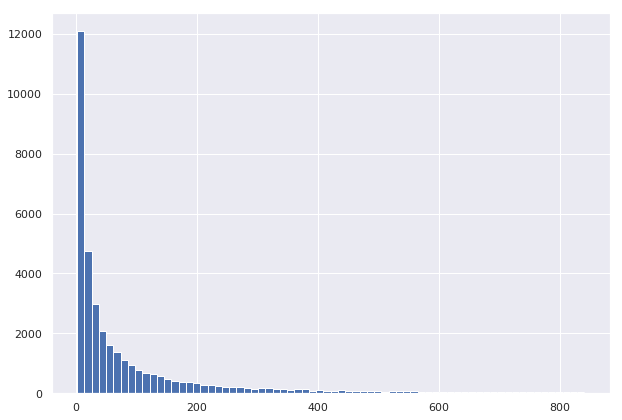

In [95]:
# Посмотрим на распределение признака до максимальной границы выбраса
df_train[df_train['Number of Reviews'] <
         reviews_IQ.higher_border.max()]['Number of Reviews'].hist(bins=70)

Заменяем выбросы на 840.

In [96]:
# Количество выбросов при границе в 840
len(data[data['Number of Reviews'] > 840]['Number of Reviews'])

1128

In [97]:
# Заменим выбросы в датафрейме data на максимальное пограничное знаечение признака
print('Будет заменено записей:', len(
    data[data['Number of Reviews'] > 840]['Number of Reviews']))
data['Number of Reviews'] = data['Number of Reviews'].apply(
    lambda x: 840 if x >= 840 else x)

Будет заменено записей: 1128


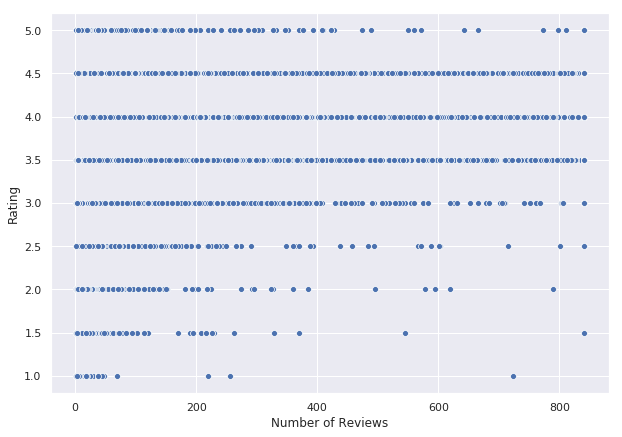

In [98]:
sns.scatterplot(data=data[data['sample'] == 1],
                x="Number of Reviews", y="Rating")

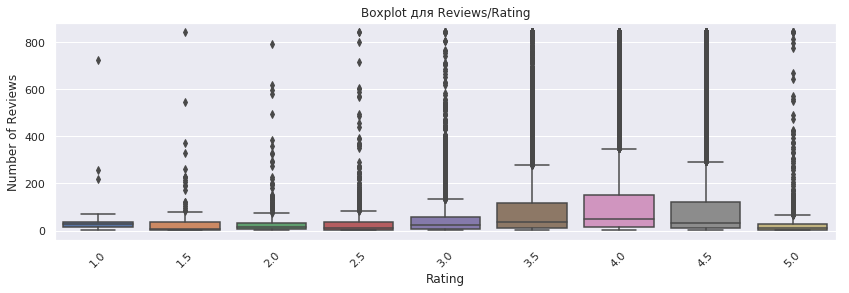

In [99]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(x='Rating', y='Number of Reviews',
            data=data[data['sample'] == 1],
            ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot для Reviews/Rating')
plt.show()

#### Признак City

Посмотрим на распределение признака, на зависимость признака от целевой переменной и других переменных.

In [100]:
# Посмотрим на распределению ресторанов по городам в %
display(pd.DataFrame(
        data['city_copies'].value_counts(normalize=True)*100))

,city_copies
London,14.386
Paris,12.216
Madrid,7.626
Barcelona,6.790
Berlin,5.410
Milan,5.388
Rome,5.178
Prague,3.632
Lisbon,3.294
Vienna,2.886


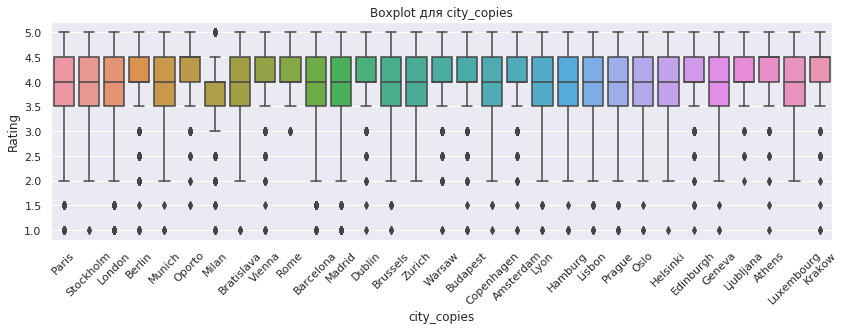

In [101]:
# Посмотрим на распределение рейтингов по городам.
get_boxplot_2('city_copies')

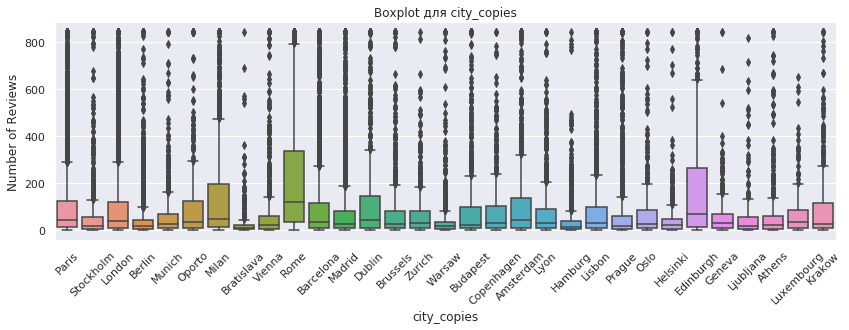

In [102]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(x='city_copies', y='Number of Reviews',
            data=data[data['sample'] == 1],
            ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot для city_copies')
plt.show()

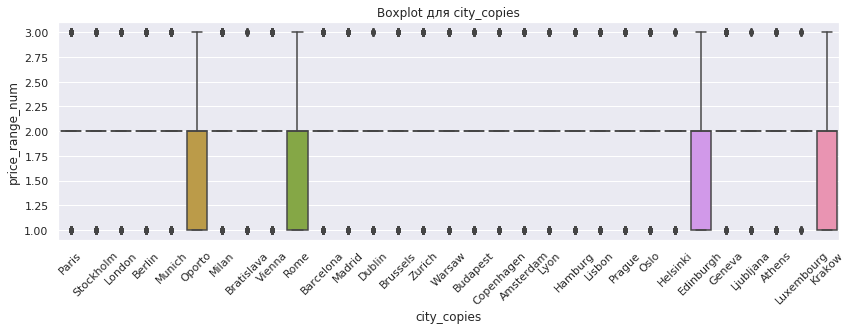

In [103]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(x='city_copies', y='price_range_num',
            data=data[data['sample'] == 1],
            ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot для city_copies')
plt.show()

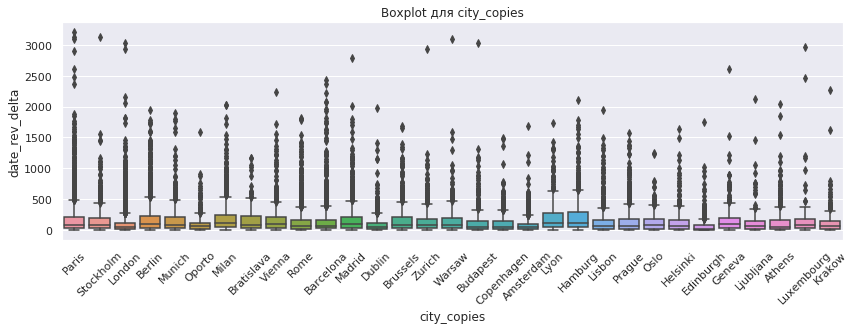

In [104]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(x='city_copies', y='date_rev_delta',
            data=data[data['sample'] == 1],
            ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot для city_copies')
plt.show()

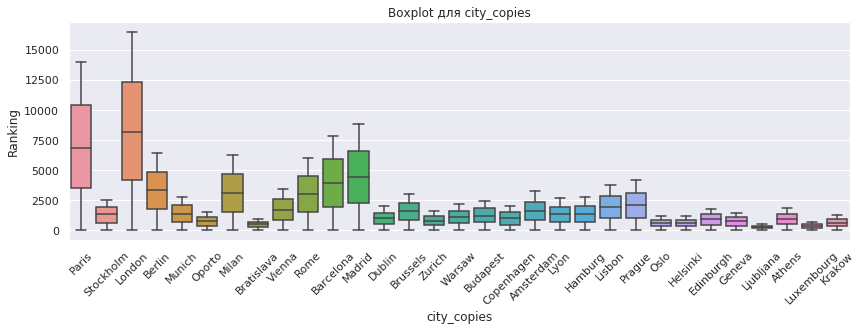

In [105]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(x='city_copies', y='Ranking',
            data=data[data['sample'] == 1],
            ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot для city_copies')
plt.show()

**Выводы по графику**:
1. Зависимость с целевой переменной:
    * Медиана по всем городам совпадает (4), кроме Милана
    * Кухня Милана самая низко-оцениваемая
    * Распределение рейтингов двух типов: а) от 3.5-4.5 с длинным хвостом до 2 b) 4-4.5 с коротким хвостом до 3.5.

    Нельзя формировать новые признаки на базе целевой переменной, но хорошо бы найти закономерность в разбиении городов на 2-3 группы.

2. Распределение рангов и городов тоже очень отличается. Выглядит так, что ранг завязан на количество ресторанов в городе. Чем больше ресторанов, тем размашистее распределение рангов между городами.
3. Дельта между двумя последними отзывами по городам практически идентична по своему распределению.
4. Количество ревью имеет больший размах для более туристических городов.

**Идеи по генерации новых признаков**:
1. Посмотреть доп. признаки по городам: население, общее количество ресторанов, ранг/общее количество рестаранов, количество туристов в год.
2. Найти признаки, по которым распределение с рейтингом будет иметь похожее на город/рейтинг для объединения в группы.

Посмотрим, как новые признаки связаны со старыми.

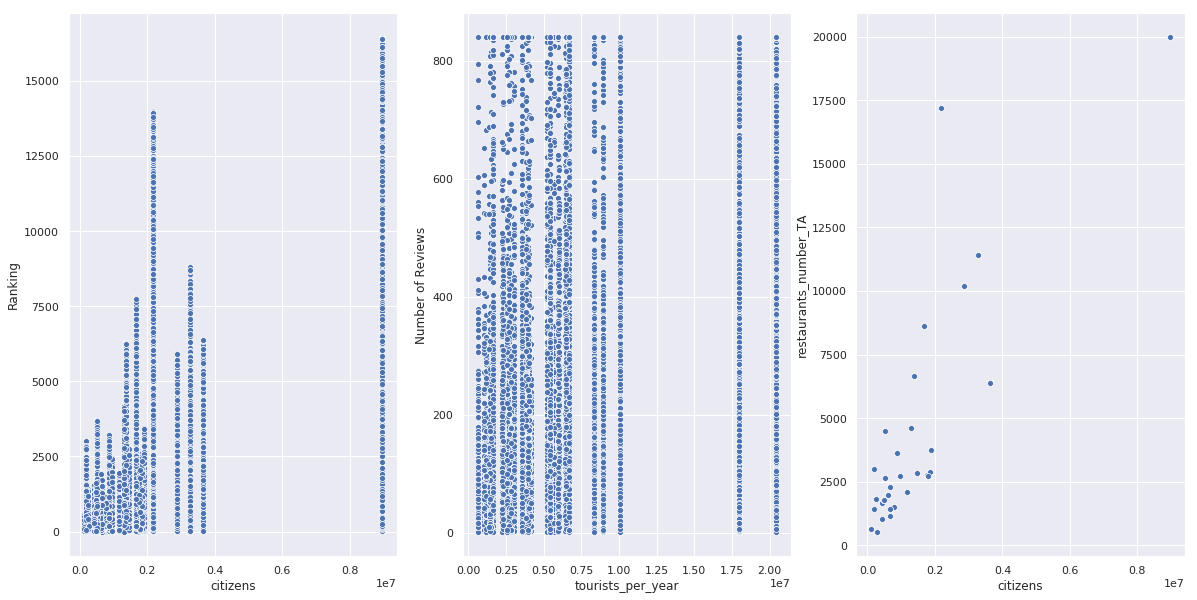

In [106]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.scatterplot(data=data[data['sample'] == 1],
                x="citizens", y="Ranking", ax=ax[0])
sns.scatterplot(data=data[data['sample'] == 1],
                x="tourists_per_year", y="Number of Reviews", ax=ax[1])
sns.scatterplot(data=data[data['sample'] == 1],
                x="citizens", y="restaurants_number_TA", ax=ax[2])

#### Признак Reviews

Посмотрим на распределение сгенерированного признака.

count    36206.000000
mean       142.548832
std        222.554361
min          0.000000
25%         20.000000
50%         67.000000
75%        173.000000
max       3296.000000
Name: date_rev_delta, dtype: float64

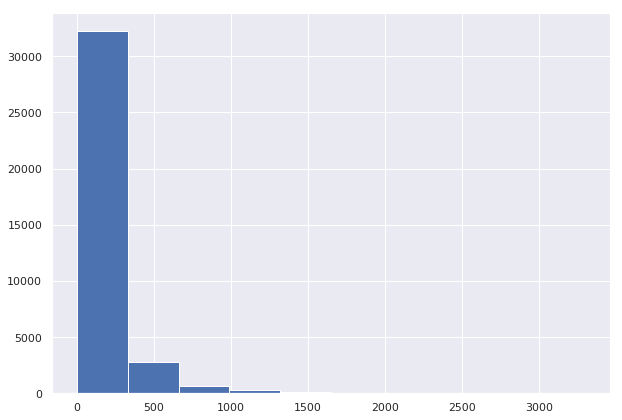

In [107]:
data['date_rev_delta'].hist()
data['date_rev_delta'].describe()

Явно есть выбросы. Обработаем их.

In [108]:
# Используем функцию для расчета границ выбросов для всех данных
iqr_analysis(data['date_rev_delta'])

25-й перцентиль: 20.0, 75-й перцентиль: 173.0, IQR: 153.0,  Границы выбросов: [-209.5, 402.5].


In [109]:
# Посмотрим, сколько записей содержит отзывы, где дельта между отзывами более года. Это чуть больше верхней границы по IQR
data[data['date_rev_delta'] > 365]['date_rev_delta'].count()

3393

In [110]:
# Заменим значение на 365*3 для выбросов (выбрано экспериментально)
data['date_rev_delta'] = data['date_rev_delta'].apply(
    lambda x: 1095 if x > 1095 else x)

Обработаем пропуски.

In [111]:
# Заменим NA на среднее
data['date_rev_delta'].fillna(data['date_rev_delta'].mean(), inplace=True)

Посмотрим, как изменилось распределение признака после замен.

count    50000.000000
mean       138.228526
std        164.626126
min          0.000000
25%         34.000000
50%        138.000000
75%        138.228526
max       1095.000000
Name: date_rev_delta, dtype: float64

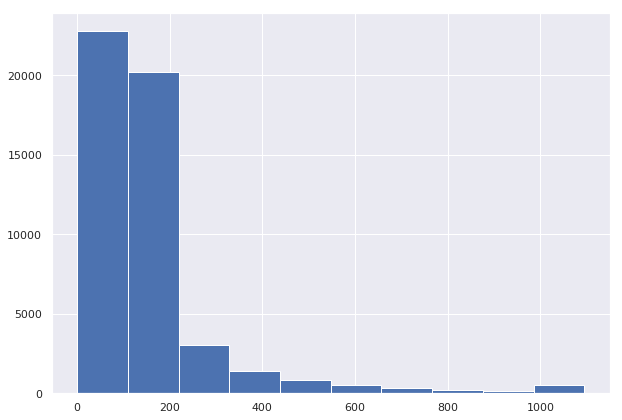

In [112]:
data['date_rev_delta'].hist()
data['date_rev_delta'].describe()

count    41886.000000
mean       405.562789
std        438.357533
min          0.000000
25%        124.000000
50%        250.000000
75%        527.000000
max       5059.000000
Name: date_rev_from_max, dtype: float64

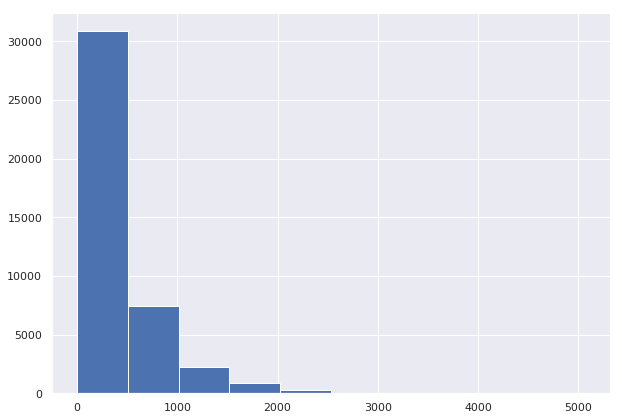

In [113]:
data['date_rev_from_max'].hist()
data['date_rev_from_max'].describe()

In [114]:
# Используем функцию для расчета границ выбросов для всех данных
iqr_analysis(data['date_rev_from_max'])

25-й перцентиль: 124.0, 75-й перцентиль: 527.0, IQR: 403.0,  Границы выбросов: [-480.5, 1131.5].


In [115]:
# Посмотрим, сколько записей содержат данные, где признак больше верхней границы
data[data['date_rev_from_max'] > 1132]['date_rev_from_max'].count()

2837

In [116]:
# Заменим значение на 1132 для выбросов
data['date_rev_from_max'] = data['date_rev_from_max'].apply(
    lambda x: 1132 if x > 1132 else x)

In [117]:
# Пропуски заменим средним
data['date_rev_from_max'].fillna(
    data['date_rev_from_max'].mean(), inplace=True)

In [118]:
data.sample()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,review_date,date_rev_1,date_rev_2,date_rev_delta,date_rev_from_max,in_chain,rank_per_ttl,ranking_num_reviews,ttl_reviews_per_city,reviews_perc_in_city_ttl
30997,2033,"['Bar', 'European', 'Dutch', 'Pub']",2038.0,$$ - $$$,78.0,[['Fine bar in de Pijp but you can find other....,/Restaurant_Review-g188590-d6413384-Reviews-He...,6413384,1,3.5,...,"[01/10/2018, 12/03/2017]",2018-01-10,2017-12-03,38.0,85.0,1,0.558509,158964.0,196988.0,0.000396


<a id="4.2"></a>

### 4.2  Распределение целевой переменной Rating

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

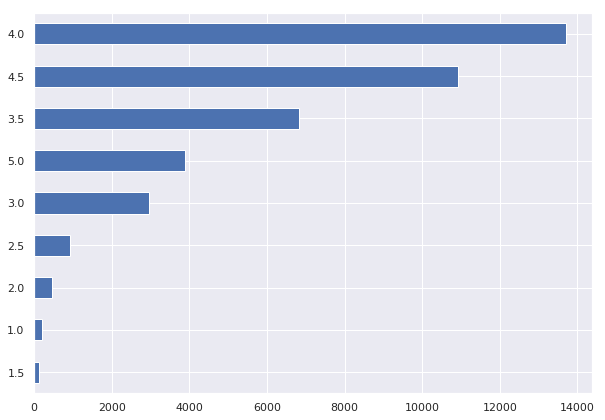

In [119]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')
df_train['Rating'].describe()

In [120]:
df_train['Rating'].unique()

array([3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

Рейтинги распределены от 1 до 5 с шагом в 0.5.

<a id="4.3"></a>

### 4.3 Корреляция признаков
Проведем корреляционный анализ.

Удалим из анализа:
* Категориальные признаки (кухни, города)
* sample (служебный признак).

In [121]:
# Сфорсмруем список признаков, которые исключаем из корреляционного анализа
cols_to_drop = ['sample', 'city_copies',  'City_Amsterdam',  'City_Athens',  'City_Barcelona', 'City_Berlin',  'City_Bratislava',  'City_Brussels',  'City_Budapest',  'City_Copenhagen',  'City_Dublin',  'City_Edinburgh',  'City_Geneva',  'City_Hamburg',  'City_Helsinki', 'City_Krakow',  'City_Lisbon',  'City_Ljubljana',  'City_London',  'City_Luxembourg',  'City_Lyon',  'City_Madrid',  'City_Milan',  'City_Munich',  'City_Oporto',  'City_Oslo',  'City_Paris', 'City_Prague',  'City_Rome',  'City_Stockholm',  'City_Vienna',  'City_Warsaw',  'City_Zurich',  'City_nan',  'Afghani',  'African',  'Albanian',  'American',  'Arabic',  'Argentinean', 'Armenian',  'Asian',  'Australian',  'Austrian',  'Azerbaijani',  'Balti',  'Bangladeshi',  'Bar',  'Barbecue', 'Belgian',  'Brazilian',  'Brew Pub',  'British',  'Burmese',  'Cafe',  'Cajun & Creole',  'Cambodian', 'Canadian',  'Caribbean', 'Caucasian',  'Central American',  'Central Asian',  'Central European', 'Chilean',  'Chinese',  'Colombian',  'Contemporary',  'Croatian',  'Cuban',  'Czech',  'Danish', 'Delicatessen',  'Diner', 'Dutch',  'Eastern European',  'Ecuadorean',  'Egyptian', 'Ethiopian',
                'European', 'Fast Food',  'Filipino',  'French', 'Fujian',  'Fusion',  'Gastropub',  'Georgian',  'German',  'Gluten Free Options',  'Greek',  'Grill',  'Halal',  'Hawaiian',  'Healthy',  'Hungarian',  'Indian',  'Indonesian',  'International',  'Irish',  'Israeli',  'Italian',  'Jamaican', 'Korean',  'Kosher',  'Latin',  'Latvian', 'Lebanese', 'Malaysian',  'Mediterranean',  'Mexican',  'Middle Eastern',  'Minority Chinese',  'Mongolian',  'Moroccan',  'Native American', 'Nepali',  'New Zealand', 'Norwegian',  'Pakistani',  'Persian',  'Peruvian',  'Pizza',  'Polish',  'Polynesian',  'Portuguese',  'Pub', 'Romanian',  'Russian',  'Salvadoran',  'Scandinavian',  'Scottish',  'Seafood', 'Singaporean',  'Slovenian',  'Soups',  'South American', 'Southwestern',  'Spanish',  'Sri Lankan',  'Steakhouse',  'Street Food',  'Sushi',  'Swedish',  'Swiss',  'Taiwanese',  'Thai',  'Tibetan',  'Tunisian',  'Turkish', 'Ukrainian',  'Uzbek',  'Vegan Options',  'Vegetarian Friendly',  'Venezuelan',  'Vietnamese',  'Welsh',  'Wine Bar',  'Xinjiang',  'Yunnan']

Text(0.5, 1.0, 'Матрица корреляций')

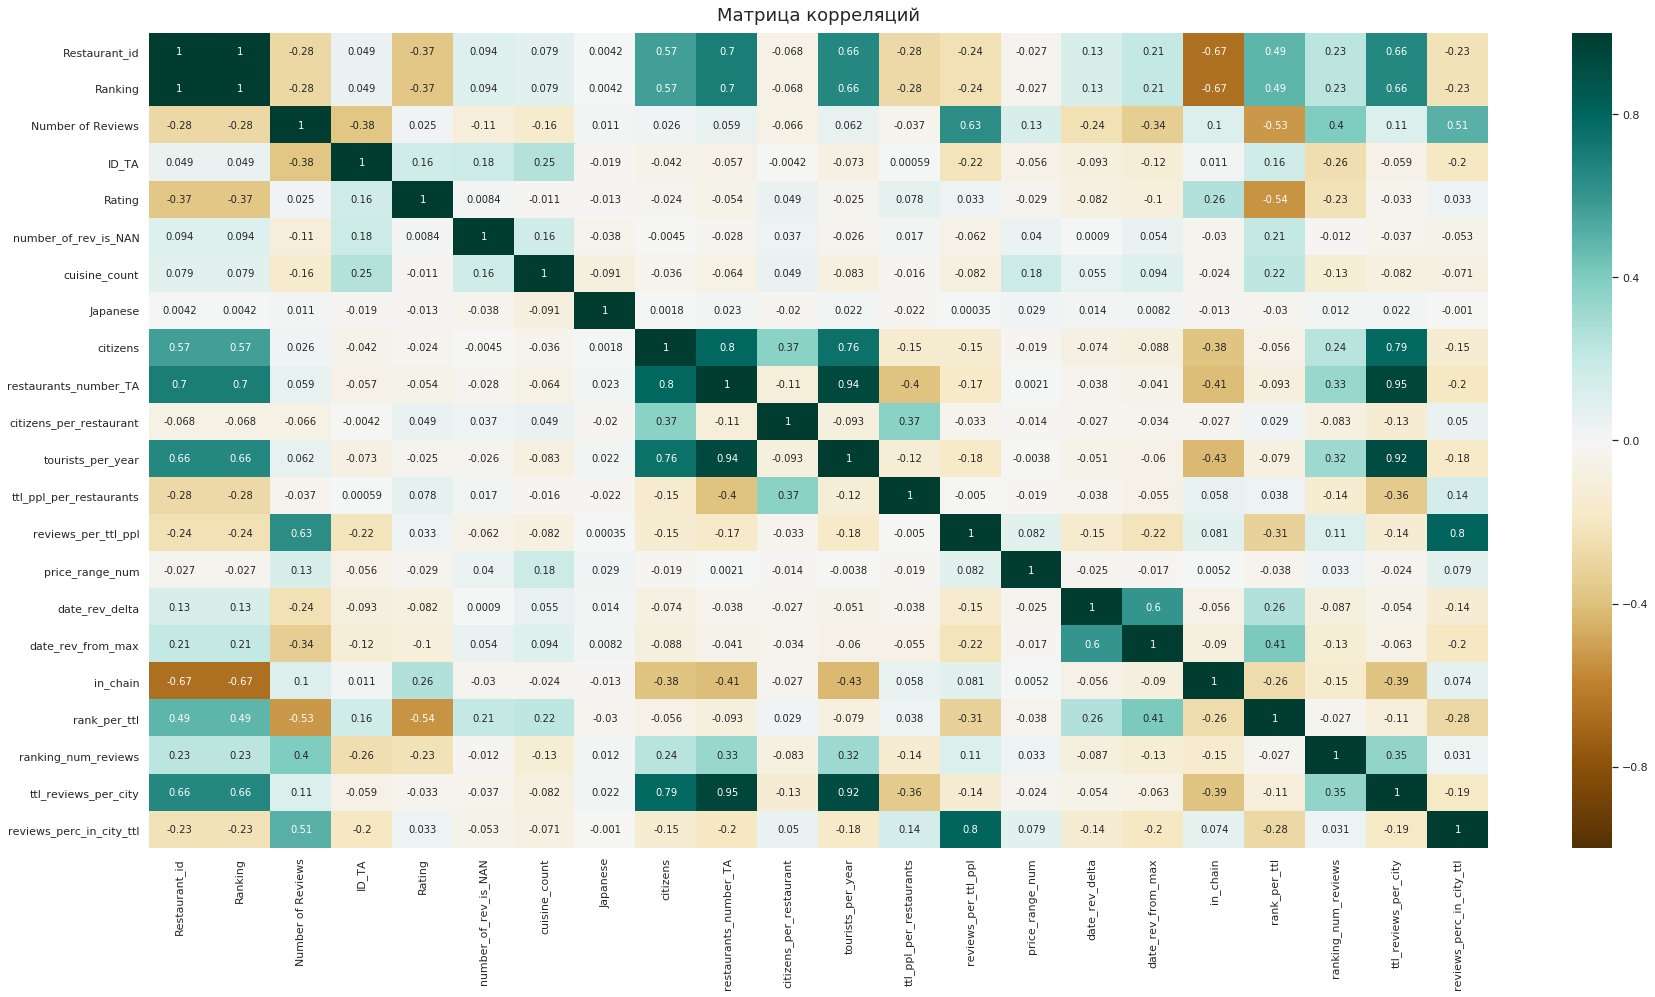

In [122]:
# Построим матрицу корреляций
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(data[data['sample'] == 1].drop(
    cols_to_drop, axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций', fontdict={'fontsize': 18}, pad=12)

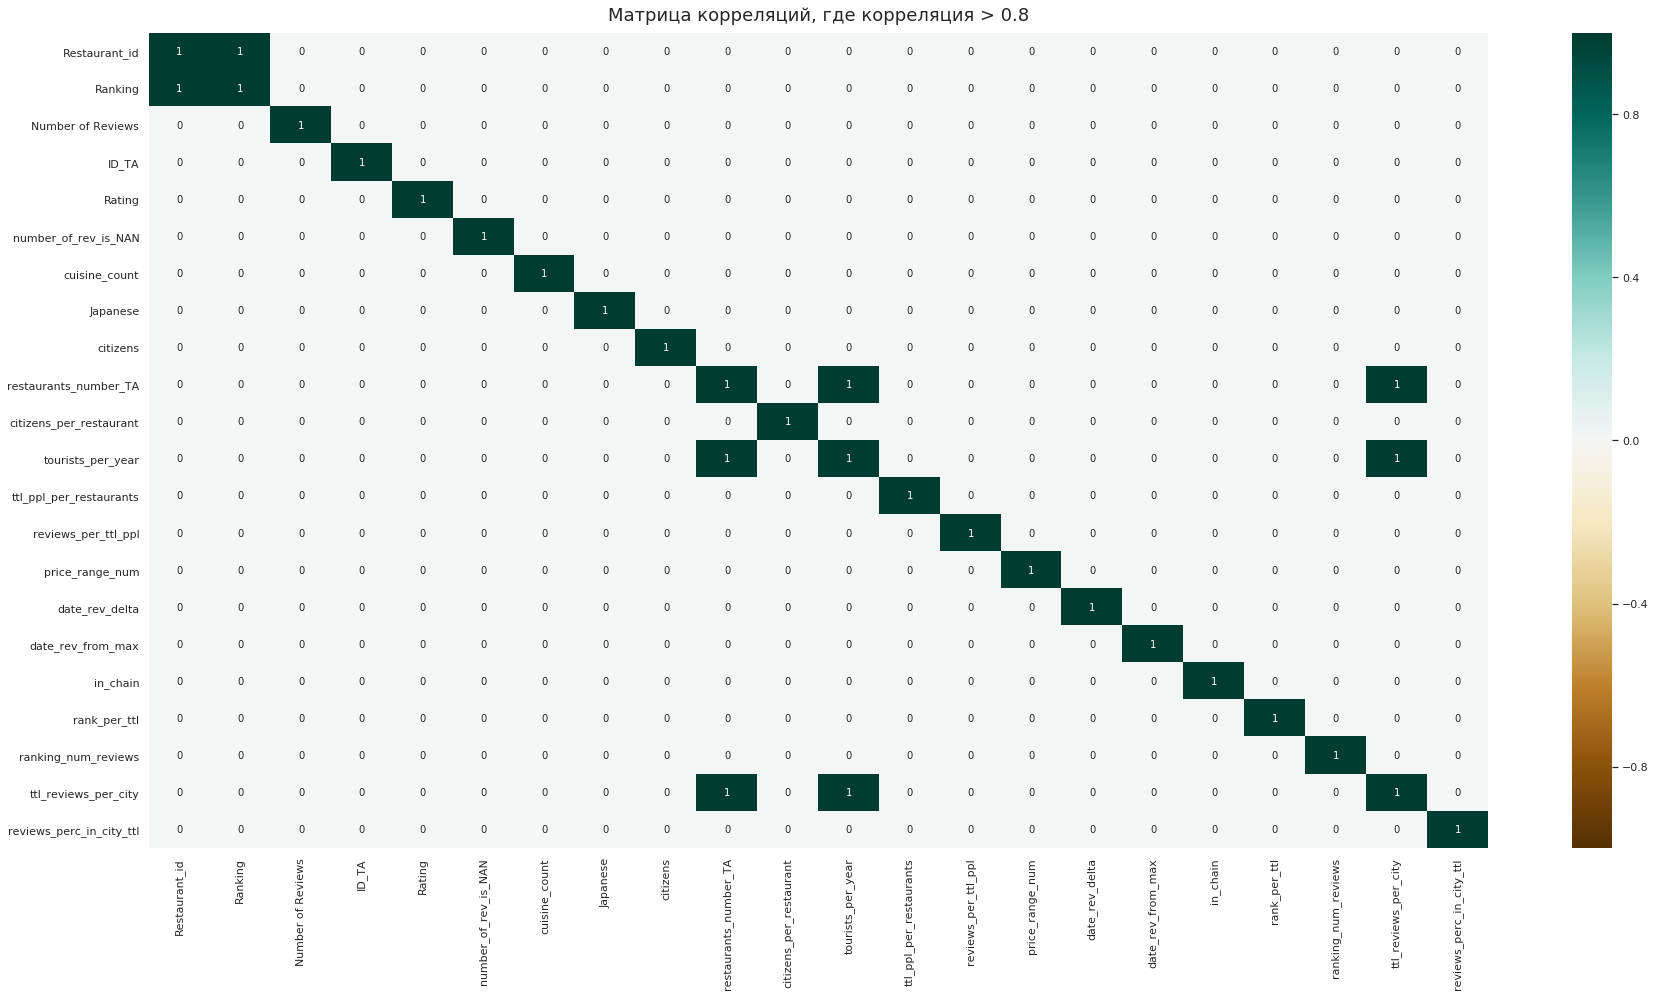

In [123]:
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(abs(data[data['sample'] == 1].drop(
    cols_to_drop, axis=1).corr()) > 0.8, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций, где корреляция > 0.8',
                  fontdict={'fontsize': 18}, pad=12)

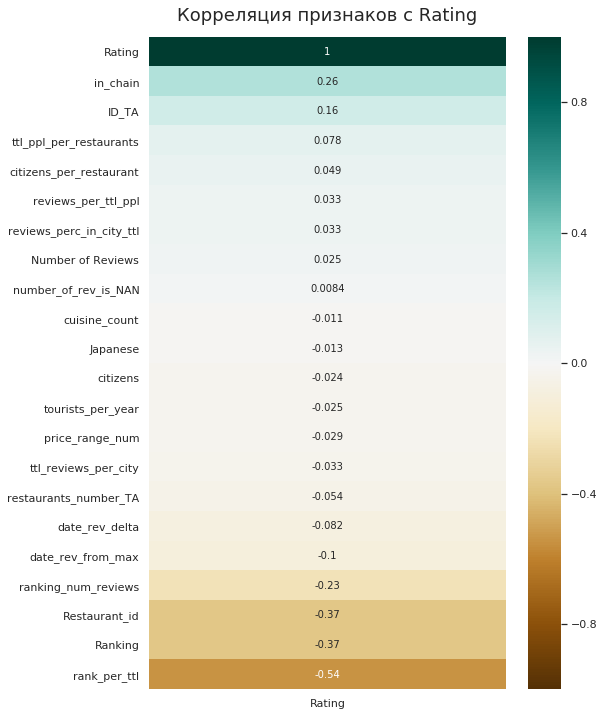

In [124]:
# Посмотрим на корреляцию признаков с целевой переменной Rating, отсортируем
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data[data['sample'] == 1].drop(
    cols_to_drop, axis=1).corr()[['Rating']].sort_values(by='Rating', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляция признаков с Rating',
                  fontdict={'fontsize': 18}, pad=16)

Сформируем список признаков, которые коллинеарны.

Для этого выставим критерий наличия корреляции больше 0.8 или -0.8.

 <a id="5"></a>

# 5. DATA PREPROCESSING


In [125]:
# Сформируем сет со скоррелированными признаками
correlated_features = set()
# Удаляем целевую переменную из матрицы коррелиций, т.к. корреляция с ней, - хорошо для модели
correlation_matrix = data[data['sample'] == 1].drop(
    ['Rating', 'sample'], axis=1).corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

print('Список скоррелированных признаков на удаление из обучения модели:',
      correlated_features)

Список скоррелированных признаков на удаление из обучения модели: {'restaurants_number_TA', 'citizens', 'Restaurant_id', 'tourists_per_year'}


In [126]:
data.drop(['tourists_per_year', 'citizens', 'Restaurant_id',
           'restaurants_number_TA'], axis=1, inplace=True)

In [127]:
for column in data.columns:
    print(type(data[column][0]), column)

<class 'str'> Cuisine Style
<class 'numpy.float64'> Ranking
<class 'str'> Price Range
<class 'numpy.float64'> Number of Reviews
<class 'str'> Reviews
<class 'str'> URL_TA
<class 'numpy.int64'> ID_TA
<class 'numpy.int64'> sample
<class 'numpy.float64'> Rating
<class 'numpy.uint8'> number_of_rev_is_NAN
<class 'list'> cuisine_style
<class 'numpy.int64'> cuisine_count
<class 'numpy.int64'> Healthy
<class 'numpy.int64'> Bar
<class 'numpy.int64'> Brazilian
<class 'numpy.int64'> Ecuadorean
<class 'numpy.int64'> Hawaiian
<class 'numpy.int64'> Uzbek
<class 'numpy.int64'> New Zealand
<class 'numpy.int64'> Persian
<class 'numpy.int64'> Tibetan
<class 'numpy.int64'> Austrian
<class 'numpy.int64'> Fujian
<class 'numpy.int64'> Nepali
<class 'numpy.int64'> Hungarian
<class 'numpy.int64'> Yunnan
<class 'numpy.int64'> Kosher
<class 'numpy.int64'> Barbecue
<class 'numpy.int64'> Polish
<class 'numpy.int64'> Czech
<class 'numpy.int64'> Latin
<class 'numpy.int64'> Vietnamese
<class 'numpy.int64'> Egyptian


In [128]:
# убираем не нужные для модели признаки
data.drop(['review_date', 'city_copies', 'country', 'Cuisine Style', 'Price Range',
           'Reviews', 'URL_TA', 'cuisine_style', 'date_rev_1', 'date_rev_2'], axis=1, inplace=True)

In [129]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

Перед тем, как отправлять  данные на обучение, разделим данные на еще один тест и трейн, для валидации. 

Это поможет проверить, как хорошо модель работает, до отправки submissiona на kaggle.

In [130]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [131]:
# Проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 174), (40000, 174), (40000, 173), (32000, 173), (8000, 173))

<a id="6"></a>

# 6. MODEL 

In [132]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [133]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission_1.csv', index=False)
sample_submission.head(10)

<a id="8"></a>

# 8. SUMMARY 

По ходу выполнения проекта:
1. Были добавлены внешние данные с информацией по городам и из TA
2. Были добавлены следующие признаки:
| Признак | Описание |
|-: |:- |
| number_of_rev_is_NAN | Наличие пропусков в изначальных данных по количеству отзывов | 
| country  | Страна, в которой находится город |
| citizens | Население города, чел |
| citizens_per_restaurant | Количество горожан на один ресторан |
| tourists_per_year| Количество туристов, посетивших город в течение года, чел |
| ttl_ppl_per_restaurants | (Количество туристов + население города) / количество ресторанов |
| reviews_per_ttl_ppl | Показывает, сколько ревью приходится на суммарных 1000 людей (жители + туристы) |
| ttl_reviews_per_city | Суммарное количество ревью по городу из выборки |
| reviews_perc_in_city_ttl | Отношения количества ревью ресторана к суммарному количеству ревью по городу из выборки |
| price_range_num | Ценовая категория ресторана: 1, 2, 3 |
| cuisine_num | Количество типов кухонь ресторана |
| review_date | Все даты ревью |
| date_rev_1 | Дата первого ревью |
| date_rev_2 | Дата второго ревью |
| in chain | Показатель, сетевой ли ресторан | 
| rank_per_ttl | показывает относительную позицию ранга ресторана к общему количеству рангов по городу |
| ranking_num_reviews | Умножение Ranking и Number of Reviews |
| ranking_num_cuisines | Умножение Ranking и cuisine_num |
| date_rev_delta | Количество дней между оставленными ревью |
| date_rev_from_max | Количество дней от последнего отзыва до самого свежего отзыва в датасете |
| City | Созданы 31 признак для кодировки города|
| Cuisine Style | Созданы 146 признака для кодировки типа кухни, включая отсуствие признака или пропуск |
3. После отбора признаков для модели были получены резултат:
    * Локальное MAE: 0.196115
    * MAE на Kaggel (для submission):  место на момент отправки).